In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#pip install albumentations==0.4.6

In [3]:
%cd drive/MyDrive/..............

/content/drive/MyDrive/TESI_FLOODNET/source


# IMPORTS

In [4]:
from preprocess import *
from dataset import FloodNetDataset
from focalloss import FocalLoss
from training import *
from attention_unet import *

from importlib import reload

from google.colab.patches import cv2_imshow

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import torch.nn as nn
from torchvision.transforms.transforms import ToTensor
import torch.nn.functional as F
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2

# DATASET

In [ ]:
train_transform = A.Compose([
                       A.Resize(600, 800),
                       A.HorizontalFlip(),
                       A.VerticalFlip(),
                       A.RandomBrightnessContrast(),
                       ToTensorV2(),   #always last
])

ds = FloodNetDataset(root_dir="../DATASET/train", transform=train_transform)

In [ ]:

np.unique(ds.__getitem__(0)[0])

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

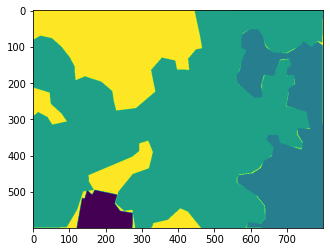

In [ ]:
img, mask = ds.__getitem__(0)
plt.imshow(mask)


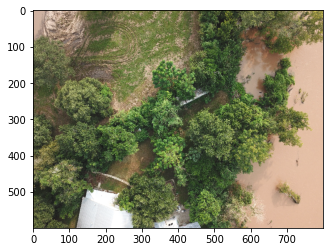

In [ ]:
plt.imshow(img.permute(1,2,0))

In [ ]:
img

tensor([[[0.7059, 0.7843, 0.8078,  ..., 0.4431, 0.5176, 0.5451],
         [0.6941, 0.7725, 0.8157,  ..., 0.6000, 0.5137, 0.4392],
         [0.7059, 0.7647, 0.8118,  ..., 0.6392, 0.4078, 0.4431],
         ...,
         [0.5412, 0.5294, 0.5412,  ..., 0.8784, 0.8667, 0.8667],
         [0.4549, 0.5216, 0.5686,  ..., 0.8706, 0.8824, 0.8667],
         [0.5804, 0.5922, 0.3804,  ..., 0.8667, 0.8863, 0.8706]],

        [[0.5922, 0.6706, 0.6941,  ..., 0.4392, 0.5059, 0.5255],
         [0.5882, 0.6627, 0.7098,  ..., 0.5647, 0.4902, 0.4078],
         [0.6078, 0.6588, 0.7020,  ..., 0.5961, 0.3765, 0.4078],
         ...,
         [0.5725, 0.5608, 0.5725,  ..., 0.7216, 0.7098, 0.7098],
         [0.4667, 0.5294, 0.5882,  ..., 0.7216, 0.7255, 0.7098],
         [0.5922, 0.6039, 0.3922,  ..., 0.7176, 0.7294, 0.7137]],

        [[0.5137, 0.6000, 0.6235,  ..., 0.1725, 0.2275, 0.2588],
         [0.5333, 0.6000, 0.6392,  ..., 0.3176, 0.2392, 0.1843],
         [0.5490, 0.5961, 0.6314,  ..., 0.3373, 0.1176, 0.

# TRAINING

In [5]:
BATCH_SIZE = 2
LR = 0.0001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#weights = torch.tensor([22.3, 27.2, 20.9, 27.5, 15.1, 7.6, 6.05, 46.5, 45.7, 2.1]).to(DEVICE)
DEVICE

'cuda'

In [6]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c5d768c5-fcd8-0a3d-b450-b2663e8724ec)


In [8]:
### HEIGHT AND WIDTH OF IMAGES
h=750
w=1000

train_transform = A.Compose([
                       A.Resize(h, w),
                       A.HorizontalFlip(),
                       A.VerticalFlip(),
                       A.RandomBrightnessContrast(),
                       ToTensorV2(),   #always last
])


val_transform = A.Compose([
                       A.Resize(h, w),
                       ToTensorV2(),   #always last
])


test_transform = A.Compose([
                       A.Resize(h, w),
                       ToTensorV2(),   #always last
                       
])






dataset_dir = "../DATASET_oversampled/"

test_ds = FloodNetDataset(root_dir=dataset_dir+"test", transform=test_transform)



train_ds, val_ds, train_dataloader, val_dataloader = get_loaders(train_path=dataset_dir+"train", 
                                                                            val_path=dataset_dir+"val", 
                                                                            batch_size=BATCH_SIZE, 
                                                                            train_transform=train_transform, 
                                                                            val_transform=val_transform,
                                                                            shuffle=True,
                                                                 )

COLLECTING IMAGES AND MASKS...
415Length of dataset: 415
Shape of images: torch.Size([3, 750, 1000])
Shape of masks: torch.Size([750, 1000])
COLLECTING IMAGES AND MASKS...
1799Length of dataset: 1799
Shape of images: torch.Size([3, 750, 1000])
Shape of masks: torch.Size([750, 1000])
COLLECTING IMAGES AND MASKS...
428Length of dataset: 428
Shape of images: torch.Size([3, 750, 1000])
Shape of masks: torch.Size([750, 1000])


In [ ]:
deeplabv3 = get_deeplab_trained(device=DEVICE, path_model="../TRAINING_LOGS/models_saved/model_912.pth", trained=True)
deeplabv3.train()


focal_loss = FocalLoss(gamma=2)

adam_opt = torch.optim.Adam([ 
    dict(params=deeplabv3.parameters(), lr=LR),
])


#sgd_opt = torch.optim.SGD([ 
 #   dict(params=deeplabv3.parameters(), lr=LR),
#])




## TESTS TO CHECK THAT THE IMAGES AND MASKS ARE OF THE RIGHT SHAPE, SIZE, ...

In [10]:
img, mask = train_ds.__getitem__(1698)
img.shape, mask.shape

(torch.Size([3, 750, 1000]), torch.Size([750, 1000]))

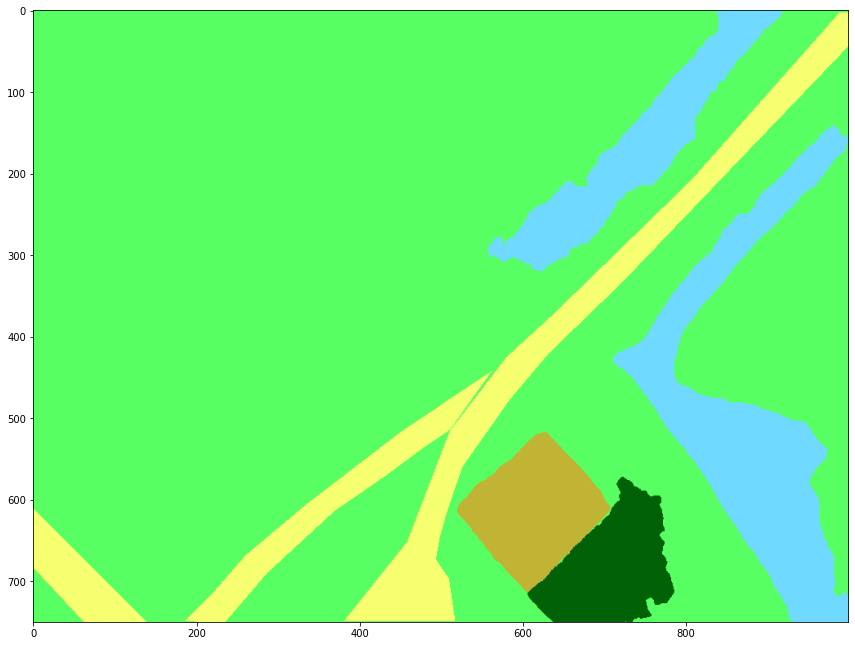

In [11]:
displayMask(mask)

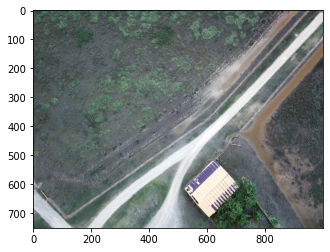

In [12]:
plt.imshow(img.permute(1,2,0))
#plt.imshow(img.numpy())
#cv2_imshow(img.numpy())
#img.permute(1,2,0).shape
#cv2.imwrite("../prova_cv2.jpg", np.array(img.permute(1,2,0)*255))

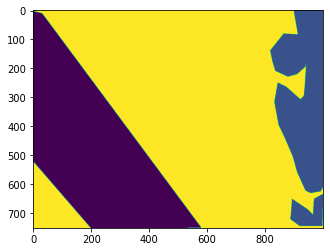

In [13]:
img, mask = val_ds.__getitem__(230)
#img.shape, mask.shape
plt.imshow(mask)

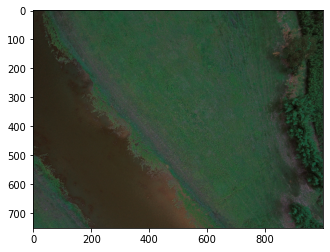

In [14]:
plt.imshow(img.permute(1,2,0))

In [15]:
len(train_dataloader), len(train_ds), len(val_dataloader), len(val_ds), len(test_ds)

(899, 1799, 214, 428, 415)

## TRAINING EPOCHS

In [ ]:
START_EPOCH=912
EPOCHS=100

train_epochs(device=DEVICE, train_dataloader=train_dataloader, val_dataloader=val_dataloader, test_ds=test_ds, model=deeplabv3, loss_fn=focal_loss, optimizer=adam_opt,
                 start_epoch=START_EPOCH, epochs=EPOCHS, path_model="../TRAINING_LOGS/models_saved/model", path_plot_train="../TRAINING_LOGS/train_plots/plot",
                 path_plot_val="../TRAINING_LOGS/val_plots/plot", path_plot_final="../TRAINING_LOGS", path_losses_train="../TRAINING_LOGS/TRAIN_LOSSES.txt", path_losses_val="../TRAINING_LOGS/VAL_LOSSES.txt")

-------------- Epoch 913 --------------
-------------- TRAINING --------------
[###############################################################################          ] 898 / 899--- Training time: 782.1638634204865 seconds ---
-------------- VALIDATION --------------
[####                 ] 213 / 214--- Validation time: 59.3739013671875 seconds ---
Calculating mIoU 
[414\415] Total IoU of class 1: 0.3476272998634148
Total IoU of class 2: 0.5678762552489898
Total IoU of class 3: 0.27835625377075757
Total IoU of class 4: 0.6167917683215469
Total IoU of class 5: 0.6119713351151364
Total IoU of class 6: 0.6387183051785645
Total IoU of class 7: 0.49392106881256176
Total IoU of class 8: 0.5159167725168751
Total IoU of class 9: 0.868292832655668
--- mIoU time: 84.26213240623474 seconds ---
Mean IoU: 0.548830210164835
------------------------
------------------------
------------------------
------------------------
-------------- Epoch 914 --------------
-------------- TRAINING ------------

# PLOTTING THE EVOLUTION OF mIoU DURING TRAINING

In [ ]:
transform_mIoU = A.Compose([
                       A.Resize(750, 1000),
                       ToTensorV2(),   #always last
                       
])

ds_mIoU = FloodNetDataset(root_dir="../DATASET/test", transform=transform_mIoU)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

deeplabv3_mIoU = get_deeplab_trained(device=DEVICE, path_model="njbhv", trained=False)
deeplabv3_mIoU.eval()

COLLECTING IMAGES AND MASKS...
391Length of dataset: 391
Shape of images: torch.Size([3, 750, 1000])
Shape of masks: torch.Size([750, 1000])


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
mIoU, _ = calculatemIoU(ds_mIoU, deeplabv3_mIoU, DEVICE)

[390\391] Total IoU of class 0: 0.0005286099600377967
Total IoU of class 1: 0.0015335126438189763
Total IoU of class 2: 0.00318975361424844
Total IoU of class 3: 0.0
Total IoU of class 4: 0.0
Total IoU of class 5: 0.013481047100052271
Total IoU of class 6: 0.0
Total IoU of class 7: 0.0004471736158231183
Total IoU of class 8: 4.335926738585885e-05
Total IoU of class 9: 0.0
--- mIoU time: 122.63478350639343 seconds ---
Mean IoU: 0.0019223456201366462


In [ ]:
array_mIoU = []
array_classes=[[],[],[],[],[],[],[],[],[],[],]
path="../mIoU/deeplabv3_baseline/"

for x in range (274, 289):
    print(x)

    deeplabv3_mIoU = get_deeplab_trained(device=DEVICE, path_model="../TRAINING_LOGS/models_saved/model_"+str(x)+".pth", trained=True)
    deeplabv3_mIoU.eval() 

    mIoU, dict_classes = calculatemIoU(ds_mIoU, deeplabv3_mIoU, DEVICE)

    array_mIoU.append(mIoU)

    for z in range(10):
        array_classes[z].append(np.average(dict_classes[z]))


    with open(path+"mIoU_epochs.txt", 'a') as f:
        f.write('Epoch ' + str(x) + ": " + str(mIoU) + "\n")  
        for sem_class in dict_classes:
            f.write("Total IoU of class " + str(sem_class) + ": " + str(np.average(dict_classes[sem_class])) + "\n")  
        f.write("------------------------------\n")


    plt.clf()
    plt.grid()
    plt.plot(array_mIoU)
    plt.savefig(path+"mean/"+str(x)+".png")
    

    for y in range(10):
        plt.clf()
        plt.grid()
        plt.plot(array_classes[y])
        plt.savefig(path + str(y) + "/" + str(x) + ".png")    

    

